# Minimizing boolean terms using the naive method
In this notebook we will generate a bunch of boolean terms (in the signature containing just `not`, `and`, `or`, `0` and `1`) and try to minimize them using basic equational laws of boolean algebra. We will first use a naive approach, applying the laws in arbitrary direction and in breadth-first order. This approach is extremely inefficient because of combinatorial explosion. Then we'll try another approach, which consists in repeatedly applying one layer of the naive method with subsequent extraction of the minimal term. The latter approach is more efficient and may be used to generate datasets.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import os
import tqdm
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append("../")

import peqsen
import peqsen.examples.term_minimization
peqsen.examples.term_minimization.tqdm_impl = tqdm.tqdm_notebook
from peqsen.examples.term_minimization import *

### Configuration
We will generate terms of size between 10 and 100. We will perform 400 rewriting steps for each term (this is not enough to get good results, but enough to eat up all the memory on my machine).

In [3]:
dirname = "temp-boolean-terms-minimization-01"
os.makedirs(dirname, exist_ok=True)

# The number of parallel processes. Note that we'll need quite a lot of memory
n_jobs = 4

max_size = 100
min_size = 10
# Generate 5 terms for each term size
count_per_size = 5
# The number of rewriting steps made by the naive mathod for each term
max_steps = 400
# The maximum number of free variables in each term
variables_num = 3

Let's start with generating some boolean terms. We take them from some distribution which is designed to generate terms of a given size, however it's NOT some well thought-out distribution with nice properties (it prefers balanced trees more than the uniform distribution, for example). In the future we might try some other distributions, but this will do for now.

In [4]:
db = MinimizedTermDB(dirname + "/boolean-terms.db")
if db.empty():
    generate_random_terms_db(db, BooleanSig.signature, n_jobs=n_jobs, 
                             min_size=min_size, max_size=max_size, count_per_size=count_per_size,
                             variables=variables_num)

Let's make sure that samples look more or less sane.

In [5]:
for mt in itertools.islice(db.values(), 3):
    print(peqsen.term_size(mt.original), mt.original)

10 not(not(or(or(not($1()), $0()), and($0(), 0()))))
10 and(and(or($2(), 1()), not(0())), or($1(), 0()))
10 not(or(or($2(), not(0())), and(not($2()), $0())))


## Naive 
Now let's minimize these terms using the naive breadth-first rule application strategy. We set the limit of the maximum number of steps to 400. It takes quite a lot of time on my machine.

In [6]:
db_naively_minimized = MinimizedTermDB(dirname + "/boolean-terms-naively-minimized-{}.db".format(max_steps))
if db_naively_minimized.empty():
    method = NaiveMinimizationMethod(theory=BooleanTheory, max_steps=max_steps)
    minimize_terms_db(db_naively_minimized, method, db.values(), n_jobs=n_jobs)

Every minimized term comes with the minimized term itself and a minimization script which contains rule application 
steps necessary to reproduce the minimization.

Let's check out several samples. The results are not very impressive, and usually out of 400 steps only about 5-35 turn out to be useful (we call this "script length"), so the naive method is very inefficient.

In [7]:
for mt in itertools.islice(db_naively_minimized.values(), 10):
    print("old size", term_size(mt.original), "new size", term_size(mt.minimized),
          "script length", script_length(mt.script))

old size 11 new size 6 script length 7
old size 10 new size 8 script length 2
old size 11 new size 3 script length 5
old size 10 new size 9 script length 2
old size 10 new size 3 script length 6
old size 10 new size 5 script length 6
old size 11 new size 5 script length 4
old size 12 new size 6 script length 3
old size 10 new size 3 script length 6
old size 12 new size 8 script length 3


Now let's draw some graphs. First of all, let's look how the minimization script length depends on the original term size. (Note that there are less terms than we have generated because I had to interrupt some term minimization processes.)

In [8]:
# Load the db into a list
list_naively_minimized = list(tqdm_impl(db_naively_minimized.values()))

In [9]:
# Create a list of tuples containing interesting information
size_len_pairs = [(term_size(mt.original), term_size(mt.minimized), script_length(mt.script),
                   mt.stats['pending_matches_dynamics'][0][1]) 
                  for mt in tqdm_impl(list_naively_minimized)]

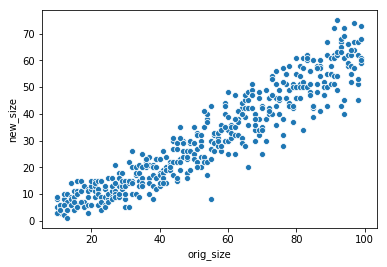

In [10]:
size_len_pairs_df = pd.DataFrame.from_records(size_len_pairs, 
                                              columns=["orig_size", "new_size", "script_len", "initial_pending"])
sns.scatterplot(x="orig_size", y="new_size", data=size_len_pairs_df)

(From now on the descriptions are under the pictures). Each circle in this graph is a term, the horizontal coordinate is its original size, the vertical coordinate is the size of the corresponding naively minimized term. The non-impressiveness of the results will be apparent when we try another method.

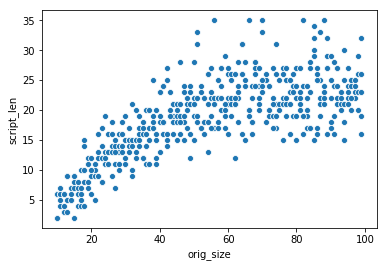

In [11]:
sns.scatterplot(x="orig_size", y="script_len", data=size_len_pairs_df)

This is the graph of the resulting script size given the original term size.

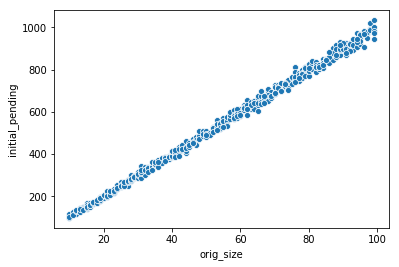

In [12]:
sns.scatterplot(x="orig_size", y="initial_pending", data=size_len_pairs_df)

This is a very important graph: the number of initial matches for each term. Since we use a breadth-first approach, and the number of steps is limited with 400, we finish the first generation of rule applications only for term sizes up to 40.

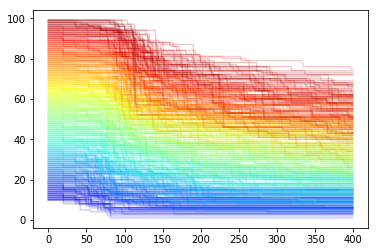

In [13]:
for mt in tqdm_impl(list_naively_minimized):
    xs = [t[0] for t in mt.stats['min_size_dynamics']]
    y0 = mt.stats['min_size_dynamics'][0][1]
    ys = [t[1] for t in mt.stats['min_size_dynamics']]
    c = plt.get_cmap('jet')(y0/100)
    plt.plot(xs, ys, alpha=0.2, c=c)

This is a bunch of "minimization curves": the size of the current minimal term given the current step. The color encodes the size of the initial term.

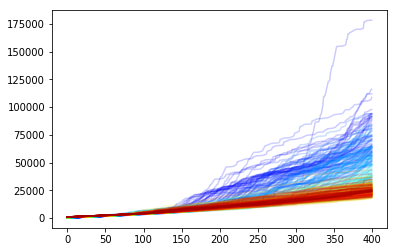

In [14]:
for mt in tqdm_impl(list_naively_minimized):
    xs = [t[0] for t in mt.stats['pending_matches_dynamics']]
    ys = [t[1] for t in mt.stats['pending_matches_dynamics']]
    y0 = mt.stats['min_size_dynamics'][0][1]
    c = plt.get_cmap('jet')(y0/100)
    plt.plot(xs, ys, alpha=0.2, c=c)

These curves show the number of pending matches (potential rule applications, in other words) depending on the current step. Interestingly it grows faster for smaller terms, probably beacause it grows with the generation index.

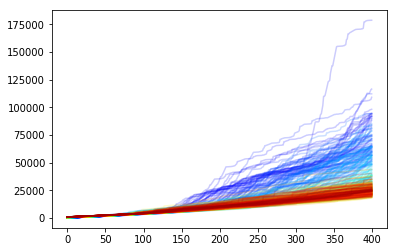

In [15]:
for mt in tqdm_impl(list_naively_minimized):
    xs = [t[0] for t in mt.stats['added_counter_dynamics']]
    ys = [t[1] for t in mt.stats['added_counter_dynamics']]
    y0 = mt.stats['min_size_dynamics'][0][1]
    c = plt.get_cmap('jet')(y0/100)
    plt.plot(xs, ys, alpha=0.2, c=c)

## Minimizing with a less naive approach
Now let's try a less naive approach. It will run the naive method for some steps, then stop, extract the minimal term, and rerun the naive method again with the extracted term as the starting point. Moreover, in each naive phase we will consider only initial matches (the first generation) to improve performance. Each naive phase will be limited to 200 steps to avoid eating up all the memory (for the same reason we use only one job), the number of phases is 5. It takes about 13 minutes on my machine.

In [16]:
db_repeatedly_minimized = \
    MinimizedTermDB(dirname + "/boolean-terms-repeatedly-naively-minimized-200.db")
if db_repeatedly_minimized.empty():
    method = OneLayerMinimizationMethod(theory=BooleanTheory, max_steps=200)
    method = RepeatedMinimizationMethod(method=method, iterations=5)
    minimize_terms_db(db_repeatedly_minimized, method, db.values(), n_jobs=1)

blue 0.5500258525659775
red 0.2916866451296551


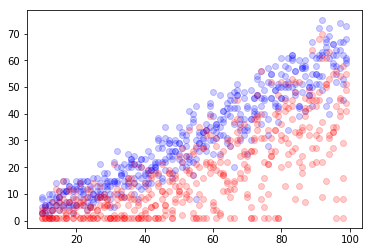

In [17]:
for (mtdb, color) in [(db_naively_minimized, 'blue'), 
                      (db_repeatedly_minimized, 'red')]:
    orig_sizes = []
    new_sizes = []
    fracs = []
    for mt in mtdb.values():
        orig_sizes.append(term_size(mt.original))
        new_sizes.append(term_size(mt.minimized))
        fracs.append(new_sizes[-1]/orig_sizes[-1])
    print(color, np.mean(fracs))
    plt.plot(orig_sizes, new_sizes, marker='o', alpha=0.2, color=color, linestyle='none')

This is the comparison of the previous approach (blue) and the new approach. The new one is obviously better, there are many terms which get reduced to size 1 (to constants).

TODO: Currently we don't generate any statistics during this kind of minimization. It would be interesting to look at the minimal term size dynamics.